# Turo Data Science Case Study

When listing a car, a host has the opportunity to set its daily price. In this process, Turo recommends a price (which the host may accept or ignore) that is designed to optimize the host’s revenue, given various properties of the listing.

1. Based on the data found in `vehicles_booking_history.csv`, produce a well-written function that accepts properties of a listing and returns a daily price that is designed to improve/optimize revenue. Here is a dictionary for the data in the .csv:
 * `vehicle_id` - vehicle's unique ID
 * `date` - calendar date
 * `is_booked` - 1 if the listing is booked
 * `tmv` - true market value of vehicle
 * `category_aggregate` - vehicle category group
 * `demand_supply_ratio` - daily demand (web and app sessions) over supply (count of live listings in the local market, e.g. a city)
 * `price` - vehicle's listed price as of the given date

2. Assuming your function is deployed in production, describe metrics and methods to gauge the success of your recomendations. 

We’re looking for a compelling process of analysis/modeling, organized and intuitive production-level code (for the function itself, as though it were part of a REST API implementation), and thoughtful consideration of measuring business impact.

Feel free to reach out with any questions!

## Analysis, Modeling, Math, etc.

(Import the data and do analysis/modeling/math or whatever, starting here.)

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from datetime import datetime
%matplotlib inline

df = pd.read_csv("vehicles_booking_history.csv")
df['weekday'] = pd.to_datetime(df.date).dt.day_name()
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
0,333483,2018-05-25,0,14569,midsize,1.902318,30.0,Friday
1,304273,2018-05-12,1,4201,compact,14.622831,39.0,Saturday
2,298081,2018-04-07,1,5724,midsize,8.659708,24.0,Saturday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
4,456223,2018-08-09,0,9666,midsize,1.297453,42.0,Thursday


In [285]:
df.category_grouped.value_counts()

suv        687
midsize    634
compact    421
upscale     80
van         68
Name: category_grouped, dtype: int64

#### Distribution of price by Weekday         
We see a right tailed distribution in the distribution plot. We also see that box plot almost have the same median for ever weekday

Text(0.5,1,'Distribution analysis by weekday')

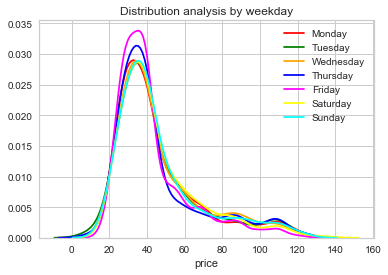

In [289]:
sns.distplot(df[df.weekday=='Monday'].price, hist=False, color='red', label='Monday')
sns.distplot(df[df.weekday=='Tuesday'].price, hist=False, color='green', label='Tuesday')
sns.distplot(df[df.weekday=='Wednesday'].price, hist=False, color='orange', label='Wednesday')
sns.distplot(df[df.weekday=='Thursday'].price, hist=False, color='blue', label='Thursday')
sns.distplot(df[df.weekday=='Friday'].price, hist=False, color='magenta', label='Friday')
sns.distplot(df[df.weekday=='Saturday'].price, hist=False, color='yellow', label='Saturday')
sns.distplot(df[df.weekday=='Sunday'].price, hist=False, color='cyan', label='Sunday')
plt.title('Distribution analysis by weekday')

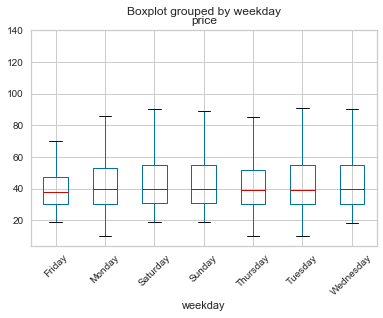

In [291]:
df.boxplot(column='price', by='weekday', rot=45)

#### Distribution of price by Booking         
We see that a vehicle tends to remain unbooked when price is higher as distribution of not booked lies on the higher end

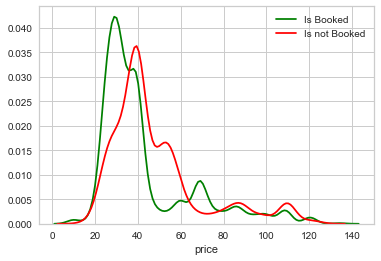

In [293]:
sns.distplot(df[df.is_booked==1].price, hist=False, color='green', label='Is Booked')
sns.distplot(df[df.is_booked==0].price, hist=False, color='red', label='Is not Booked')

#### Distribution of price by category of vehicle         
As expected we see that the price is different for different vehicles

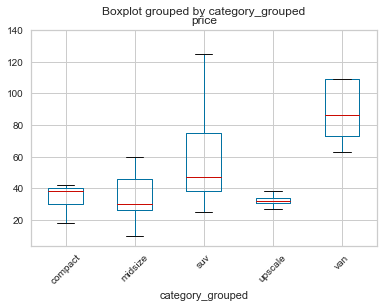

In [288]:
df.boxplot(column='price', by='category_grouped', rot=45)

#### Price analysis for SUV         
Lets analyze for vehicle category SUV.    
 - A right tailed distribution by weekday indicating some weekdays have higher price vs Friday which has price on the lower side     
 - as seen above the price of unbooked SUV tends to be on the higher side    
 - The box plots show difference in prices by weekday Friday being the lowest
 


In [187]:
dfSuv = df[df.category_grouped=='suv']
dfSuv.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
5,508104,2019-02-19,1,5148,suv,4.303872,38.0,Tuesday
9,405192,2018-09-05,0,18802,suv,0.890217,60.0,Wednesday
11,406331,2018-11-10,0,39102,suv,5.671775,87.0,Saturday
13,406331,2018-11-20,0,39102,suv,5.412565,87.0,Tuesday


Text(0.5,1,'Distribution analysis by weekday for SUV')

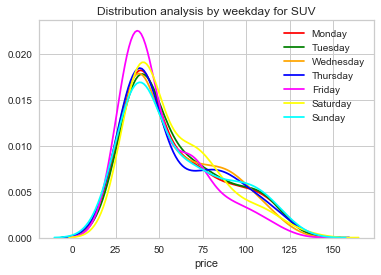

In [292]:
sns.distplot(dfSuv[dfSuv.weekday=='Monday'].price, hist=False, color='red', label='Monday')
sns.distplot(dfSuv[dfSuv.weekday=='Tuesday'].price, hist=False, color='green', label='Tuesday')
sns.distplot(dfSuv[dfSuv.weekday=='Wednesday'].price, hist=False, color='orange', label='Wednesday')
sns.distplot(dfSuv[dfSuv.weekday=='Thursday'].price, hist=False, color='blue', label='Thursday')
sns.distplot(dfSuv[dfSuv.weekday=='Friday'].price, hist=False, color='magenta', label='Friday')
sns.distplot(dfSuv[dfSuv.weekday=='Saturday'].price, hist=False, color='yellow', label='Saturday')
sns.distplot(dfSuv[dfSuv.weekday=='Sunday'].price, hist=False, color='cyan', label='Sunday')
plt.title('Distribution analysis by weekday for SUV')

Text(0.5,1,'Distribution analysis by Booking for SUV')

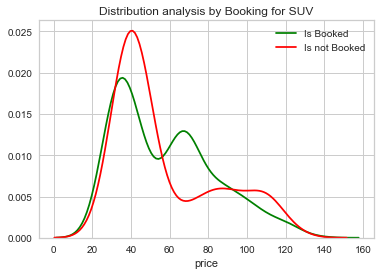

In [299]:
sns.distplot(dfSuv[dfSuv.is_booked==1].price, hist=False, color='green', label='Is Booked')
sns.distplot(dfSuv[dfSuv.is_booked==0].price, hist=False, color='red', label='Is not Booked')
plt.title('Distribution analysis by Booking for SUV')

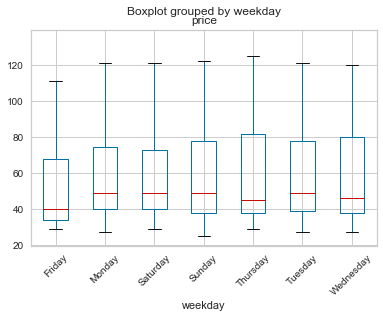

In [190]:
dfSuv.boxplot(column='price', by='weekday', rot=45)

In [196]:
groupedDF = df.groupby(['category_grouped', 'weekday'])
meanDF = groupedDF.mean()[['price']].reset_index()#.median()[['price']]
print(meanDF.head())
medianDF = groupedDF.median()[['price']].reset_index()
print(medianDF.head())

  category_grouped   weekday      price
0          compact    Friday  35.044776
1          compact    Monday  34.103448
2          compact  Saturday  35.100000
3          compact    Sunday  35.277778
4          compact  Thursday  33.923077
  category_grouped   weekday  price
0          compact    Friday   38.0
1          compact    Monday   37.0
2          compact  Saturday   38.5
3          compact    Sunday   39.0
4          compact  Thursday   36.0


#### Comparative Price analysis by category and weekday
I have created a heatmap to compare mean(first heatmap)of price of category by weekday. The values are zero mean normalized(by row) for the sake of comparison of prices by category.    
- The high and low prices for different category vehicles are different, indicating that not all vehicles have peak prices on the same weekday.     
- I assumed that price would be high(assuming high price = high demand) on the weekends as people might use the vehicles for a getaway, it clearly indicates that different vehicles are used for different purposes for example vans have high prices on Thursdays and Fridays whereas upscale vehicles have higher price on Monday and compact vehicles have higher price on Tuesday.    
- We can say that Vans are used for weekend getaways, whereas upscale and compact vehicles are used for meetings or going to offices, but the price of the upscale and compacts fall in the week so we cannot say for sure about these cars.


Text(0.5,1,'Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

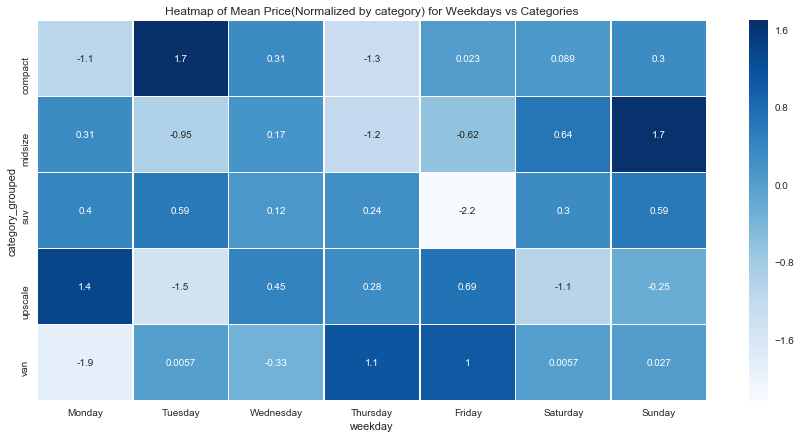

In [197]:
pivotedMean = meanDF.pivot(index='category_grouped', columns='weekday', values='price')
#zero mean normalization
# 1: substract mean
dfNorm = pivotedMean.sub(pivotedMean.mean(axis=1), axis=0)
# 2: divide by standard dev
dfNorm = dfNorm.div( pivotedMean.std(axis=1), axis=0)
# Re-ordering columns
dfNorm = dfNorm[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']]

fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(dfNorm, annot=True, linewidths=.5, cmap="Blues")
ax.set_title('Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

#### Comparative Price analysis by Vehicle and weekday
As there were limited number of vehicles I created a similar heatmap as above for them, no values for few vehicle ids mean that they have the same mean value throughout the week(eg: vehicle id: 289235)    

Here also we see the similar trend that the vehicle price is not uniform throughout the week

Text(0.5,1,'Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

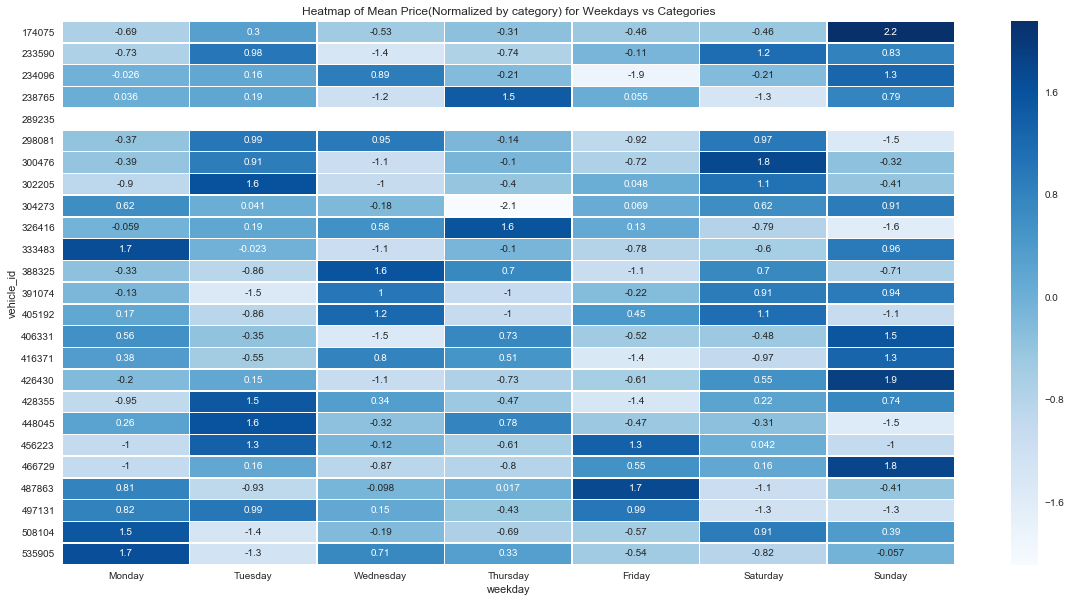

In [295]:
groupedDF = df.groupby(['vehicle_id', 'weekday'])
meanDF = groupedDF.mean()[['price']].reset_index()

pivotedVehicle = meanDF.pivot(index='vehicle_id', columns='weekday', values='price')
# 1: substract mean
dfNorm = pivotedVehicle.sub(pivotedVehicle.mean(axis=1), axis=0)
# 2: divide by standard dev
dfNorm = dfNorm.div(pivotedVehicle.std(axis=1), axis=0 )
# Re-ordering columns
dfNorm = dfNorm[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']]
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(dfNorm, annot=True, linewidths=.5, cmap="Blues")
ax.set_title('Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

#### Scatter plot of numerical features
From the below scatter plot matrix we see that there is some sort of positive correlation between tmv(true market value) and price which completely makes sense as higher the cost of the vehicle higher is its price.    
Whereas I also expected the demand supply ratio to be positively co-related to price as the demand to supply ratio increase the price should increase but we do not see a clear indication in this scatter plot, which can be confirmed from below correlation matrix.

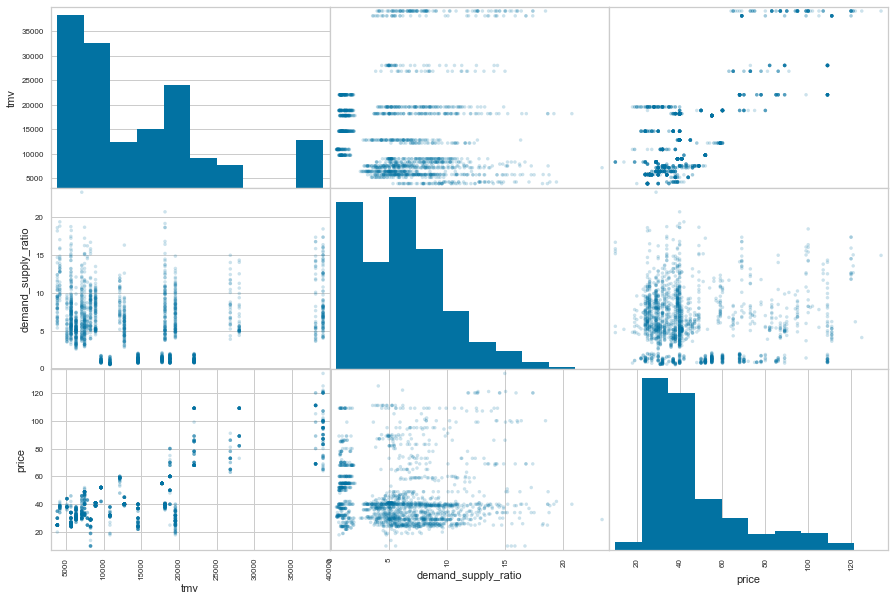

In [201]:
dfNumeric = df[['tmv','demand_supply_ratio', 'price']]
ax = pd.plotting.scatter_matrix(dfNumeric, alpha=0.2, figsize=(15, 10))

In [204]:

dfNumeric.corr(method ='pearson')

,tmv,demand_supply_ratio,price
tmv,1.000000,-0.013403,0.784662
demand_supply_ratio,-0.013403,1.000000,-0.047594
price,0.784662,-0.047594,1.000000


In [205]:
dfNumeric.corr(method ='kendall')

,tmv,demand_supply_ratio,price
tmv,1.000000,-0.137334,0.463586
demand_supply_ratio,-0.137334,1.000000,-0.105607
price,0.463586,-0.105607,1.000000


#### Scatter plot of price vs tmv categorized by vehicle category
From the below scatter plot we see that the vehicle category with same tmv(multiple records of vehicles for different date) have different price and understandably so.


Text(0.5,1,'Scatter plot of price vs tmv categorized by vehicle category')

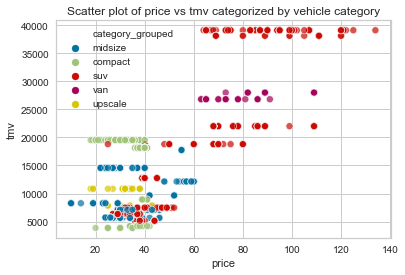

In [300]:
sns.scatterplot('price', 'tmv', data=df, hue='category_grouped', s=50, alpha=0.7)
plt.title('Scatter plot of price vs tmv categorized by vehicle category')

#### Scatter plot of price vs demand suply ratio categorized by vehicle category and booking

In this scatter plot the categories of vehicles are categorized by colors and booking is indicated by different markers, cross indicates booking and circle indicates no booking as shown in the legends.    

We can observe that when there is higher demand supply ratio there are more bookings.    
We also see that higher demand supply ratio does not indicate high price(We can use this to maximize the profit). 


Text(0.5,1,'Scatter plot of price vs demand suply ratio categorized by vehicle category and booking')

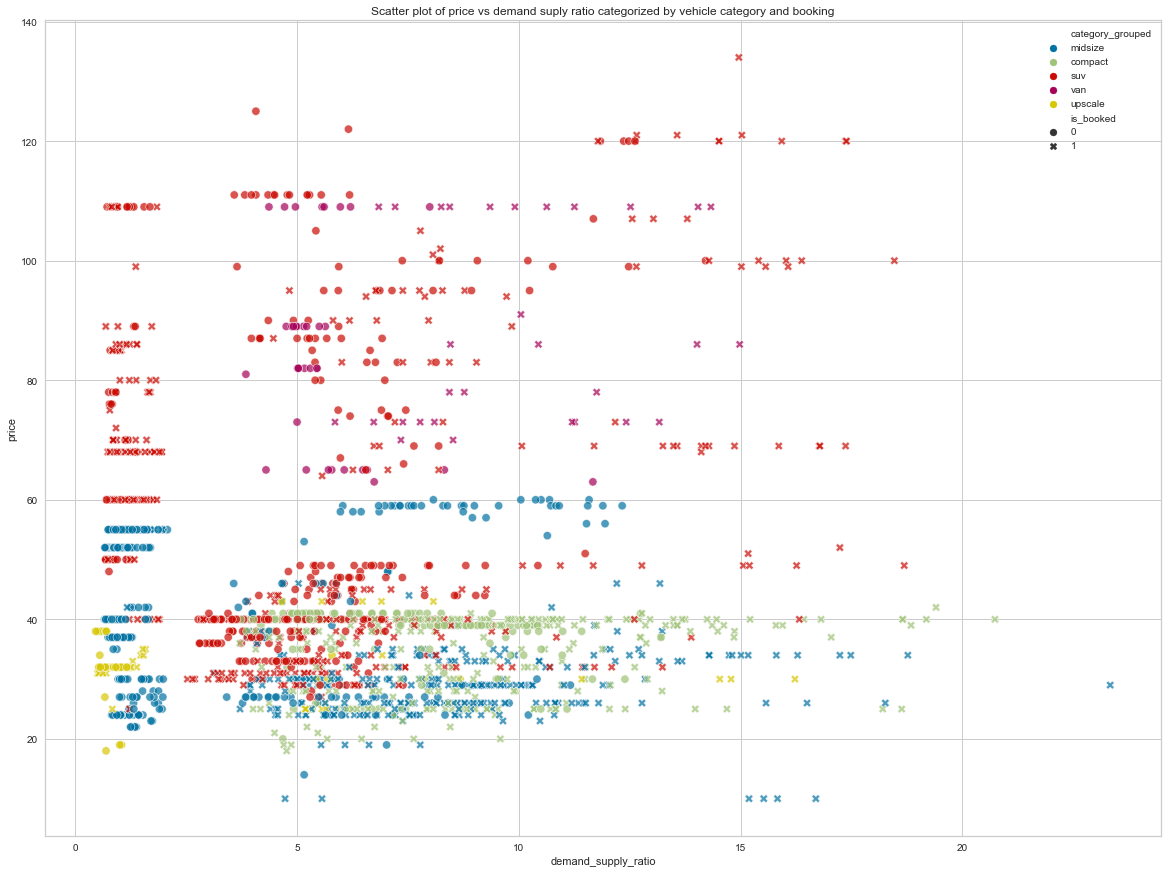

In [303]:
# dfNumeric.plot.scatter(x='price', y='demand_supply_ratio', c='category_grouped')
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot('demand_supply_ratio', 'price', data=df, hue='category_grouped', style="is_booked", s=70, alpha=0.7)
plt.title('Scatter plot of price vs demand suply ratio categorized by vehicle category and booking')

### Apply Linear Regression         
As we want to formulate a function to get the price based on the variables we have, we can use a simple linear regression as we can learn the weights for every feature and calculate the price as shown below.   
Price = W<sub>0</sub> + W<sub>1</sub> (X<sub>1</sub>) + W<sub>2</sub> (X<sub>2</sub>) + W<sub>3</sub> (X<sub>3</sub>) + ...    

W<sub>0</sub> is the bias term or intercept    
W<sub>1</sub>,...,W<sub>n</sub> are the model parameters or weights     
X<sub>1</sub>,...,X<sub>n</sub> are feature values     

As we saw before there was no collinearity in the numerical predictor variable in the correlation matrix before, hence they are linearly independent. However this does not affect the predictive power but individual predictor variable’s impact on the response variable could be calculated wrongly.    
I will do one hot encoding for category of vehicles and extracted weekday from the date.     


In [206]:
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
0,333483,2018-05-25,0,14569,midsize,1.902318,30.0,Friday
1,304273,2018-05-12,1,4201,compact,14.622831,39.0,Saturday
2,298081,2018-04-07,1,5724,midsize,8.659708,24.0,Saturday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
4,456223,2018-08-09,0,9666,midsize,1.297453,42.0,Thursday


In [207]:
categoryDummies = pd.get_dummies(df.category_grouped,prefix='category')
categoryDummies.head()

,category_compact,category_midsize,category_suv,category_upscale,category_van
0,0,1,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,1,0,0
4,0,1,0,0,0


In [208]:
weekdayDummies = pd.get_dummies(df.weekday,prefix='weekdays')
weekdayDummies.head()

,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0


In [209]:
preparedDf = pd.concat([df, categoryDummies, weekdayDummies], axis=1)
preparedDf = preparedDf.drop(['vehicle_id', 'date', 'category_grouped', 'weekday'], axis=1)
preparedDf.head()

,is_booked,tmv,demand_supply_ratio,price,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday
0,0,14569,1.902318,30.0,0,1,0,0,0,1,0,0,0,0,0,0
1,1,4201,14.622831,39.0,1,0,0,0,0,0,0,1,0,0,0,0
2,1,5724,8.659708,24.0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,39102,13.570390,121.0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,9666,1.297453,42.0,0,1,0,0,0,0,0,0,0,1,0,0


In [210]:
Y = preparedDf.price
X = preparedDf.drop(['price'], axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.3, random_state = 10)

linearRegressor = LinearRegression()
linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)
yPredictionTrain = linearRegressor.predict(xTrain)

print("Coeff of Determination score for Training Dataset = ",linearRegressor.score(xTrain, yTrain))
print("Coeff of Determination score for Test Dataset = ",linearRegressor.score(xTest, yTest))

print("RMSE for Test Data = ",math.sqrt(mean_squared_error(yTest, yPrediction)))
print("RMSE for Training Data = ",math.sqrt(mean_squared_error(yTrain, yPredictionTrain)))

Coeff of Determination score for Training Dataset =  0.7243266557441206
Coeff of Determination score for Test Dataset =  0.7056024929920243
RMSE for Test Data =  11.57851196416234
RMSE for Training Data =  11.834892532970647


#### Analysis of prediction
we see that coefficient of determination or R<sup>2</sup> values for test and train dataset indicate that about 70% of variance in the dependent variable can be collectively explained by independent variables. However the RMSE(Root Mean Squared Error) is around 11.5       

From the below scattered plot we see that there are some higer values in price(or possible outliers) which are not predicted well.     
If given more time I could increase the models prediction power by doing proper outlier analysis and removing them, using various transformations to transform the data and using regularization techniques to generalize the model(it still seems to have generalized).     

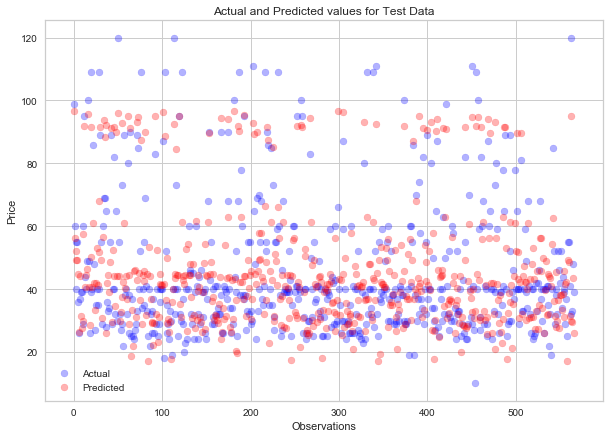

In [213]:
_, ax = plt.subplots(figsize=(10,7))
ax.scatter(x = range(0, yTest.size), y=yTest, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, yPrediction.size), y=yPrediction, c = 'red', label = 'Predicted', alpha = 0.3)
plt.title('Actual and Predicted values for Test Data')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

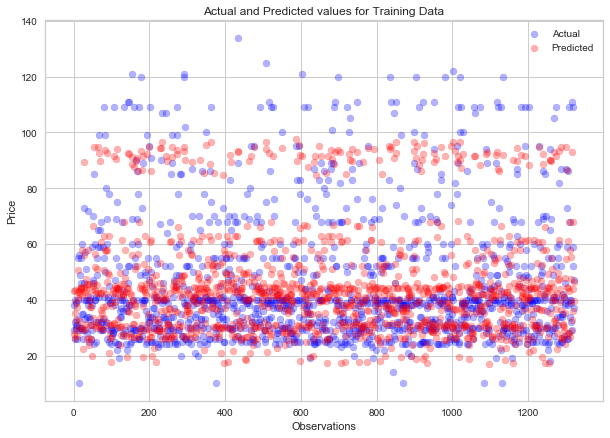

In [214]:
_, ax = plt.subplots(figsize=(10,7))
ax.scatter(x = range(0, yTrain.size), y=yTrain, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, yPredictionTrain.size), y=yPredictionTrain, c = 'red', label = 'Predicted', alpha = 0.3)
plt.title('Actual and Predicted values for Training Data')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Residual analysis        
In the below figure we see that there are some residuals having higher negative values indicating the higher values of price not predicted correctly, hence the longer left tail in the distribution plot. It still looks like a normal distribution with almost 0 mean indicating no bias(or very low bias) and       

In the prediction error diagram below a diagonal line indicates perfect regressor however even the current line does not seem too bad.   

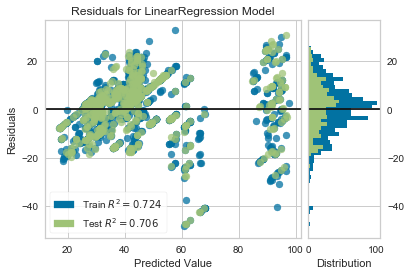

In [211]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(linearRegressor)
visualizer.fit(xTrain, yTrain)  # Fit the training data to the model
visualizer.score(xTest, yTest)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Text(0.5,1,'Residual Distribution')

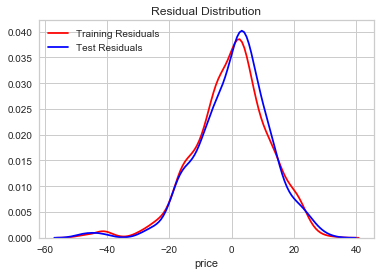

In [215]:
sns.distplot(yPredictionTrain-yTrain, hist=False, color='red', label='Training Residuals')
sns.distplot(yPrediction-yTest, hist=False, color='blue', label='Test Residuals')
plt.title('Residual Distribution')

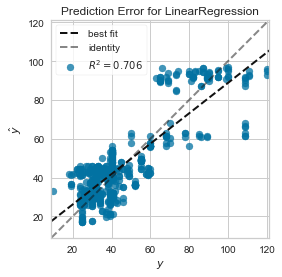

In [212]:
from yellowbrick.regressor import PredictionError
visualizer = PredictionError(linearRegressor)

visualizer.fit(xTrain, yTrain)  # Fit the training data to the visualizer
visualizer.score(xTest, yTest)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

In [228]:
weights = linearRegressor.coef_
intercept = linearRegressor.intercept_
print("Linear Regression Weights :", weights)
print("feature order :", X.columns)
print("Linear Regression Intercept :",intercept)

Linear Regression Weights : [-5.17815438e+00  1.58547692e-03  2.62698754e-01 -1.14446468e+01
 -5.21773494e+00  5.16424740e+00 -8.30845141e+00  1.98065857e+01
 -3.97243455e-01 -9.39448075e-01  1.10413572e+00  1.23901729e+00
 -4.91923327e-01 -1.61978513e-01 -3.52559643e-01]
feature order : Index(['is_booked', 'tmv', 'demand_supply_ratio', 'category_compact',
       'category_midsize', 'category_suv', 'category_upscale', 'category_van',
       'weekdays_Friday', 'weekdays_Monday', 'weekdays_Saturday',
       'weekdays_Sunday', 'weekdays_Thursday', 'weekdays_Tuesday',
       'weekdays_Wednesday'],
      dtype='object')
Linear Regression Intercept : 26.460572299850316


In [231]:
np.dot(np.array(linearRegressor.coef_),np.array(X.iloc[1]))+26.460572299850316

21.443894907464443

In [226]:
linearRegressor.predict(np.array([X.iloc[1]]))

array([21.44389491])

In [232]:
X.head()

,is_booked,tmv,demand_supply_ratio,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday
0,0,14569,1.902318,0,1,0,0,0,1,0,0,0,0,0,0
1,1,4201,14.622831,1,0,0,0,0,0,0,1,0,0,0,0
2,1,5724,8.659708,0,1,0,0,0,0,0,1,0,0,0,0
3,1,39102,13.570390,0,0,1,0,0,0,1,0,0,0,0,0
4,0,9666,1.297453,0,1,0,0,0,0,0,0,0,1,0,0


In [233]:
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
0,333483,2018-05-25,0,14569,midsize,1.902318,30.0,Friday
1,304273,2018-05-12,1,4201,compact,14.622831,39.0,Saturday
2,298081,2018-04-07,1,5724,midsize,8.659708,24.0,Saturday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
4,456223,2018-08-09,0,9666,midsize,1.297453,42.0,Thursday


## Recommendation function

(Write a function that takes the properties of the listing and returns a price here.)

In [273]:
def predict(weights, intercept, inputData):
    """Function to Predict the price of the Input Data by W.X + intercept

    Args:
        weights (List): The weights of Linear regression Model.
        intercept (Int): The intercept of Linear regression Model.
        inputData (List or pd.Series): The Input Data in raw format.

    Returns:
        Int: returns the predicted price.
    """
    
    inputDataFormat = ['vehicle_id', 'date', 'is_booked', 'tmv', 'category_grouped',
       'demand_supply_ratio']
    featureVecFormat = ['is_booked', 'tmv', 'demand_supply_ratio', 'category_compact',
       'category_midsize', 'category_suv', 'category_upscale', 'category_van',
       'weekdays_Friday', 'weekdays_Monday', 'weekdays_Saturday',
       'weekdays_Sunday', 'weekdays_Thursday', 'weekdays_Tuesday',
       'weekdays_Wednesday']
    
#     Numerical or Boolean features
    numericalFeatures = ['is_booked', 'tmv', 'demand_supply_ratio'] 

#     get Weekday from date
    weekday = datetime.strptime(inputData[1], '%Y-%m-%d').strftime("%A")
    
#     Initialize value of feature vec with 0
    featureVecMap = dict(zip(featureVecFormat, [0] * len(featureVecFormat)))
#     Convert input to dict
    inputDataMap = dict(zip(inputDataFormat, inputData))
    
#     Set numerical values
    for feature in numericalFeatures:
        featureVecMap[feature] = inputDataMap[feature]
    
#     set present categorical values to 1 
    featureVecMap['weekdays_'+weekday] = 1
    featureVecMap['category_'+inputDataMap['category_grouped']] = 1
      
#     get feature vector in form of list
    featureVec = list(featureVecMap.values())
    
    weights = np.array(weights)
    featureVec = np.array(featureVec)
    
    return np.dot(weights, featureVec) + intercept

In [281]:
predict(weights, intercept, df.iloc[0])

44.44414378124678

In [275]:
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
0,333483,2018-05-25,0,14569,midsize,1.902318,30.0,Friday
1,304273,2018-05-12,1,4201,compact,14.622831,39.0,Saturday
2,298081,2018-04-07,1,5724,midsize,8.659708,24.0,Saturday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
4,456223,2018-08-09,0,9666,midsize,1.297453,42.0,Thursday


## Measuring business impact

(Tell us how you'd gauge the success/business impact of the suggested price.)

We can maximize 
We can say that the predicted price is good only when we can optimize the profit and that can be optimized we get more number of bookings 

In [307]:
print('total cost of test data :',sum(yTest))
print('total cost of predicted data :',sum(yPrediction))

total cost of test data : 25619.0
total cost of predicted data : 26013.94828775518
